In [76]:
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymysql
import pymongo

In [77]:
# Wait for the databases to be ready.
def wait_for_services():
    time.sleep(10)  # Wait for 10 seconds for the services to start.

In [78]:
# MySQL connection.
mysql_conn = pymysql.connect(host='localhost', user='root', password='root')
mysql_cursor = mysql_conn.cursor()

In [79]:
# Create the database if it doesn't exist.
mysql_cursor.execute("CREATE DATABASE IF NOT EXISTS test_db;")
mysql_cursor.execute("USE test_db;")

0

In [80]:
# Create MySQL table.
mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS FTIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        FULLTEXT(name)
    );
""")

mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS IDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255),
        INDEX(name)
    );
""")

mysql_cursor.execute("""
    CREATE TABLE IF NOT EXISTS NOIDX_table (
        id INT AUTO_INCREMENT PRIMARY KEY,
        name VARCHAR(255),
        country VARCHAR(255)
    );
""")

0

In [81]:
# MongoDB connection.
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["test_db"]
mongo_collection = mongo_db["test_collection"]

In [82]:
# Create indexes in MongoDB.
mongo_collection.create_index([("name", pymongo.TEXT)])  # Create full-text index on a field.
mongo_collection.create_index([("name", 1)])  # Create regular index in ascending order.

'name_1'

In [83]:
# Function to insert data into MySQL.
def insert_data_mysql(table, data, transactional=True):
    if transactional:
        mysql_conn.begin() # Start transaction.
    sql = f"INSERT INTO {table} (name, country) VALUES (%s, %s)"
    mysql_cursor.execute(sql, data)
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [84]:
# Function to insert data into MongoDB.
# In MongoDB, every single document insert is an atomic operation.
def insert_data_mongo(data, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                mongo_collection.insert_one(data) # MongoDB does not have explicit transactions for single operations.
    else:
        mongo_collection.insert_one(data)

In [85]:
# Function to delete data from MySQL.
def delete_data_mysql(table, name, transactional=True):
    if transactional:
        mysql_conn.begin()  # Start transaction.
    sql = f"DELETE FROM {table} WHERE name = %s"
    mysql_cursor.execute(sql, (name,))
    if transactional:
        mysql_conn.commit()  # Commit transaction.

In [86]:
# Function to delete data from MongoDB.
def delete_data_mongo(name, transactional=True):
    if transactional:
        with mongo_client.start_session() as session:
            with session.start_transaction():
                mongo_collection.delete_one({"name": name}) # MongoDB does not have explicit transactions for single operations.
    else:
        mongo_collection.delete_one({"name": name})

In [87]:
# Use faker library to generate fake data.
# from faker import Faker

# fake = Faker()
# id_ = random.randint(1, 10000)
# name = fake.city()
# country = fake.country()
# coord = (str(faker.longitude()), str(faker.latitude()))

# Generate fake sample data.
def create_sample_data(num_records):
    sample_data = []
    for i in range(num_records):
        sample_data.append({
            "id": i,
            "name": f"City_{i}",
            "country": "RU",
            "coord": {"lon": random.uniform(-180, 180), "lat": random.uniform(-90, 90)}
        })
    return sample_data

In [88]:
# Experiment.
# Types of Queries:
#   A. Indexes:
#       1. FTIDX: Full-text indexing for efficient text searches.
#       2. IDX: Regular indexing for general query optimization.
#       3. NOIDX: No indexing, leading to potential performance issues for queries.
#   B. Transactional:
#      1. Transaction
#      2. Non-transaction

results = []
for i in range(100):
    # Generate random data.
    name = f"City_{random.randint(1, 1000)}"
    country = "IN"
    
    # Insert data with different conditions.
    for index_type in ['FTIDX', 'IDX', 'NOIDX']:
    	for transactional in [True, False]:
        	# Measure insert time.
        	start_time = time.time()
        	insert_data_mysql("_".join([index_type, "table"]), (name, country), transactional)
        	mysql_duration = (time.time() - start_time) * 1000
        	
        	start_time = time.time()
        	insert_data_mongo({"name": name, "country": country}, transactional)
        	mongo_duration = (time.time() - start_time) * 1000
        	
        	# Measure delete time.
        	start_time = time.time()
        	delete_data_mysql("_".join([index_type, "table"]), name, transactional)
        	mysql_delete_duration = (time.time() - start_time) * 1000
        	
        	start_time = time.time()
        	delete_data_mongo(name, transactional)
        	mongo_delete_duration = (time.time() - start_time) * 1000
        	
        	# Store results.
        	results.append({
        		"Index Type": index_type,
        		"Transaction": "TX" if transactional else "NOTX",
        		"MySQL Insert Time (ms)": mysql_duration,
        		"MongoDB Insert Time (ms)": mongo_duration,
        		"MySQL Delete Time (ms)": mysql_delete_duration,
        		"MongoDB Delete Time (ms)": mongo_delete_duration
        	})

In [89]:
# Convert results to Pandas' DataFrame.
results_df = pd.DataFrame(results)
results_df.head

<bound method NDFrame.head of     Index Type Transaction  MySQL Insert Time (ms)  MongoDB Insert Time (ms)  \
0        FTIDX          TX               44.095755                  4.133463   
1        FTIDX        NOTX                0.785351                  1.156807   
2          IDX          TX               17.964363                  1.419544   
3          IDX        NOTX                0.788212                  1.279354   
4        NOIDX          TX               20.587921                  1.324415   
..         ...         ...                     ...                       ...   
595      FTIDX        NOTX                0.791550                  1.119614   
596        IDX          TX               23.563147                  1.281261   
597        IDX        NOTX                1.265526                  2.221346   
598      NOIDX          TX               23.411989                  2.273083   
599      NOIDX        NOTX                1.247406                  2.300024   

     MySQ

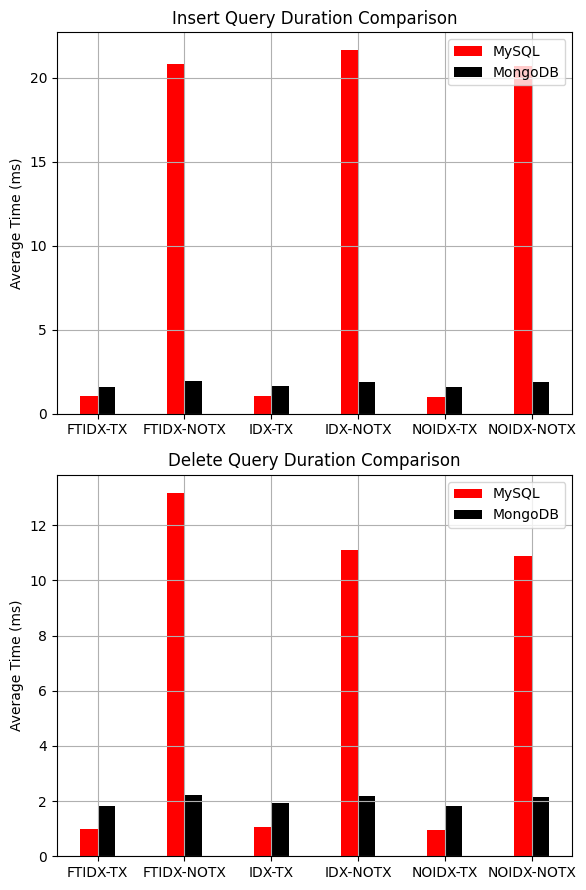

In [95]:
# Create a new column for combined labels.
results_df['Label'] = results_df['Index Type'] + '-' + results_df['Transaction']

# Set the bar width.
bar_width = 0.2

# Create subplots for each query type.
fig, axs = plt.subplots(2, 1, figsize=(6, 9))

# Define query types and their corresponding column names.
query_types = ['Insert', 'Delete']
mysql_columns = ['MySQL Insert Time (ms)', 'MySQL Delete Time (ms)']
mongo_columns = ['MongoDB Insert Time (ms)', 'MongoDB Delete Time (ms)']

# Loop through each query type and create a bar plot.
for i, query in enumerate(query_types):
    # Set the positions of the bars on the x-axis.
    x = np.arange(len(results_df['Label'].unique()))
    
    # Plot MySQL and MongoDB times for the current query type.
    axs[i].bar(x - bar_width/2,
               results_df.groupby('Label')[mysql_columns[i]].mean(),
               width=bar_width,
               label='MySQL', color='red')
    
    axs[i].bar(x + bar_width/2, 
               results_df.groupby('Label')[mongo_columns[i]].mean(), 
               width=bar_width, 
               label='MongoDB', color='black')
    
    # Set the x-ticks and labels.
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(results_df['Label'].unique())
    axs[i].set_title(f'{query} Query Duration Comparison')
    axs[i].set_ylabel('Average Time (ms)')
    axs[i].legend()
    axs[i].grid()

# Adjust layout and show the plots.
plt.tight_layout()
plt.show()

In [91]:
# Close connections.
# TODO: Uncomment all commands.
# mysql_cursor.close()
# mysql_conn.close()
# mongo_client.close()